# Импорты

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [ ]:
df = pd.read_csv('./gdrive/MyDrive/Colab_Notebooks/train.csv', index_col=0)

# Первичная визуализация

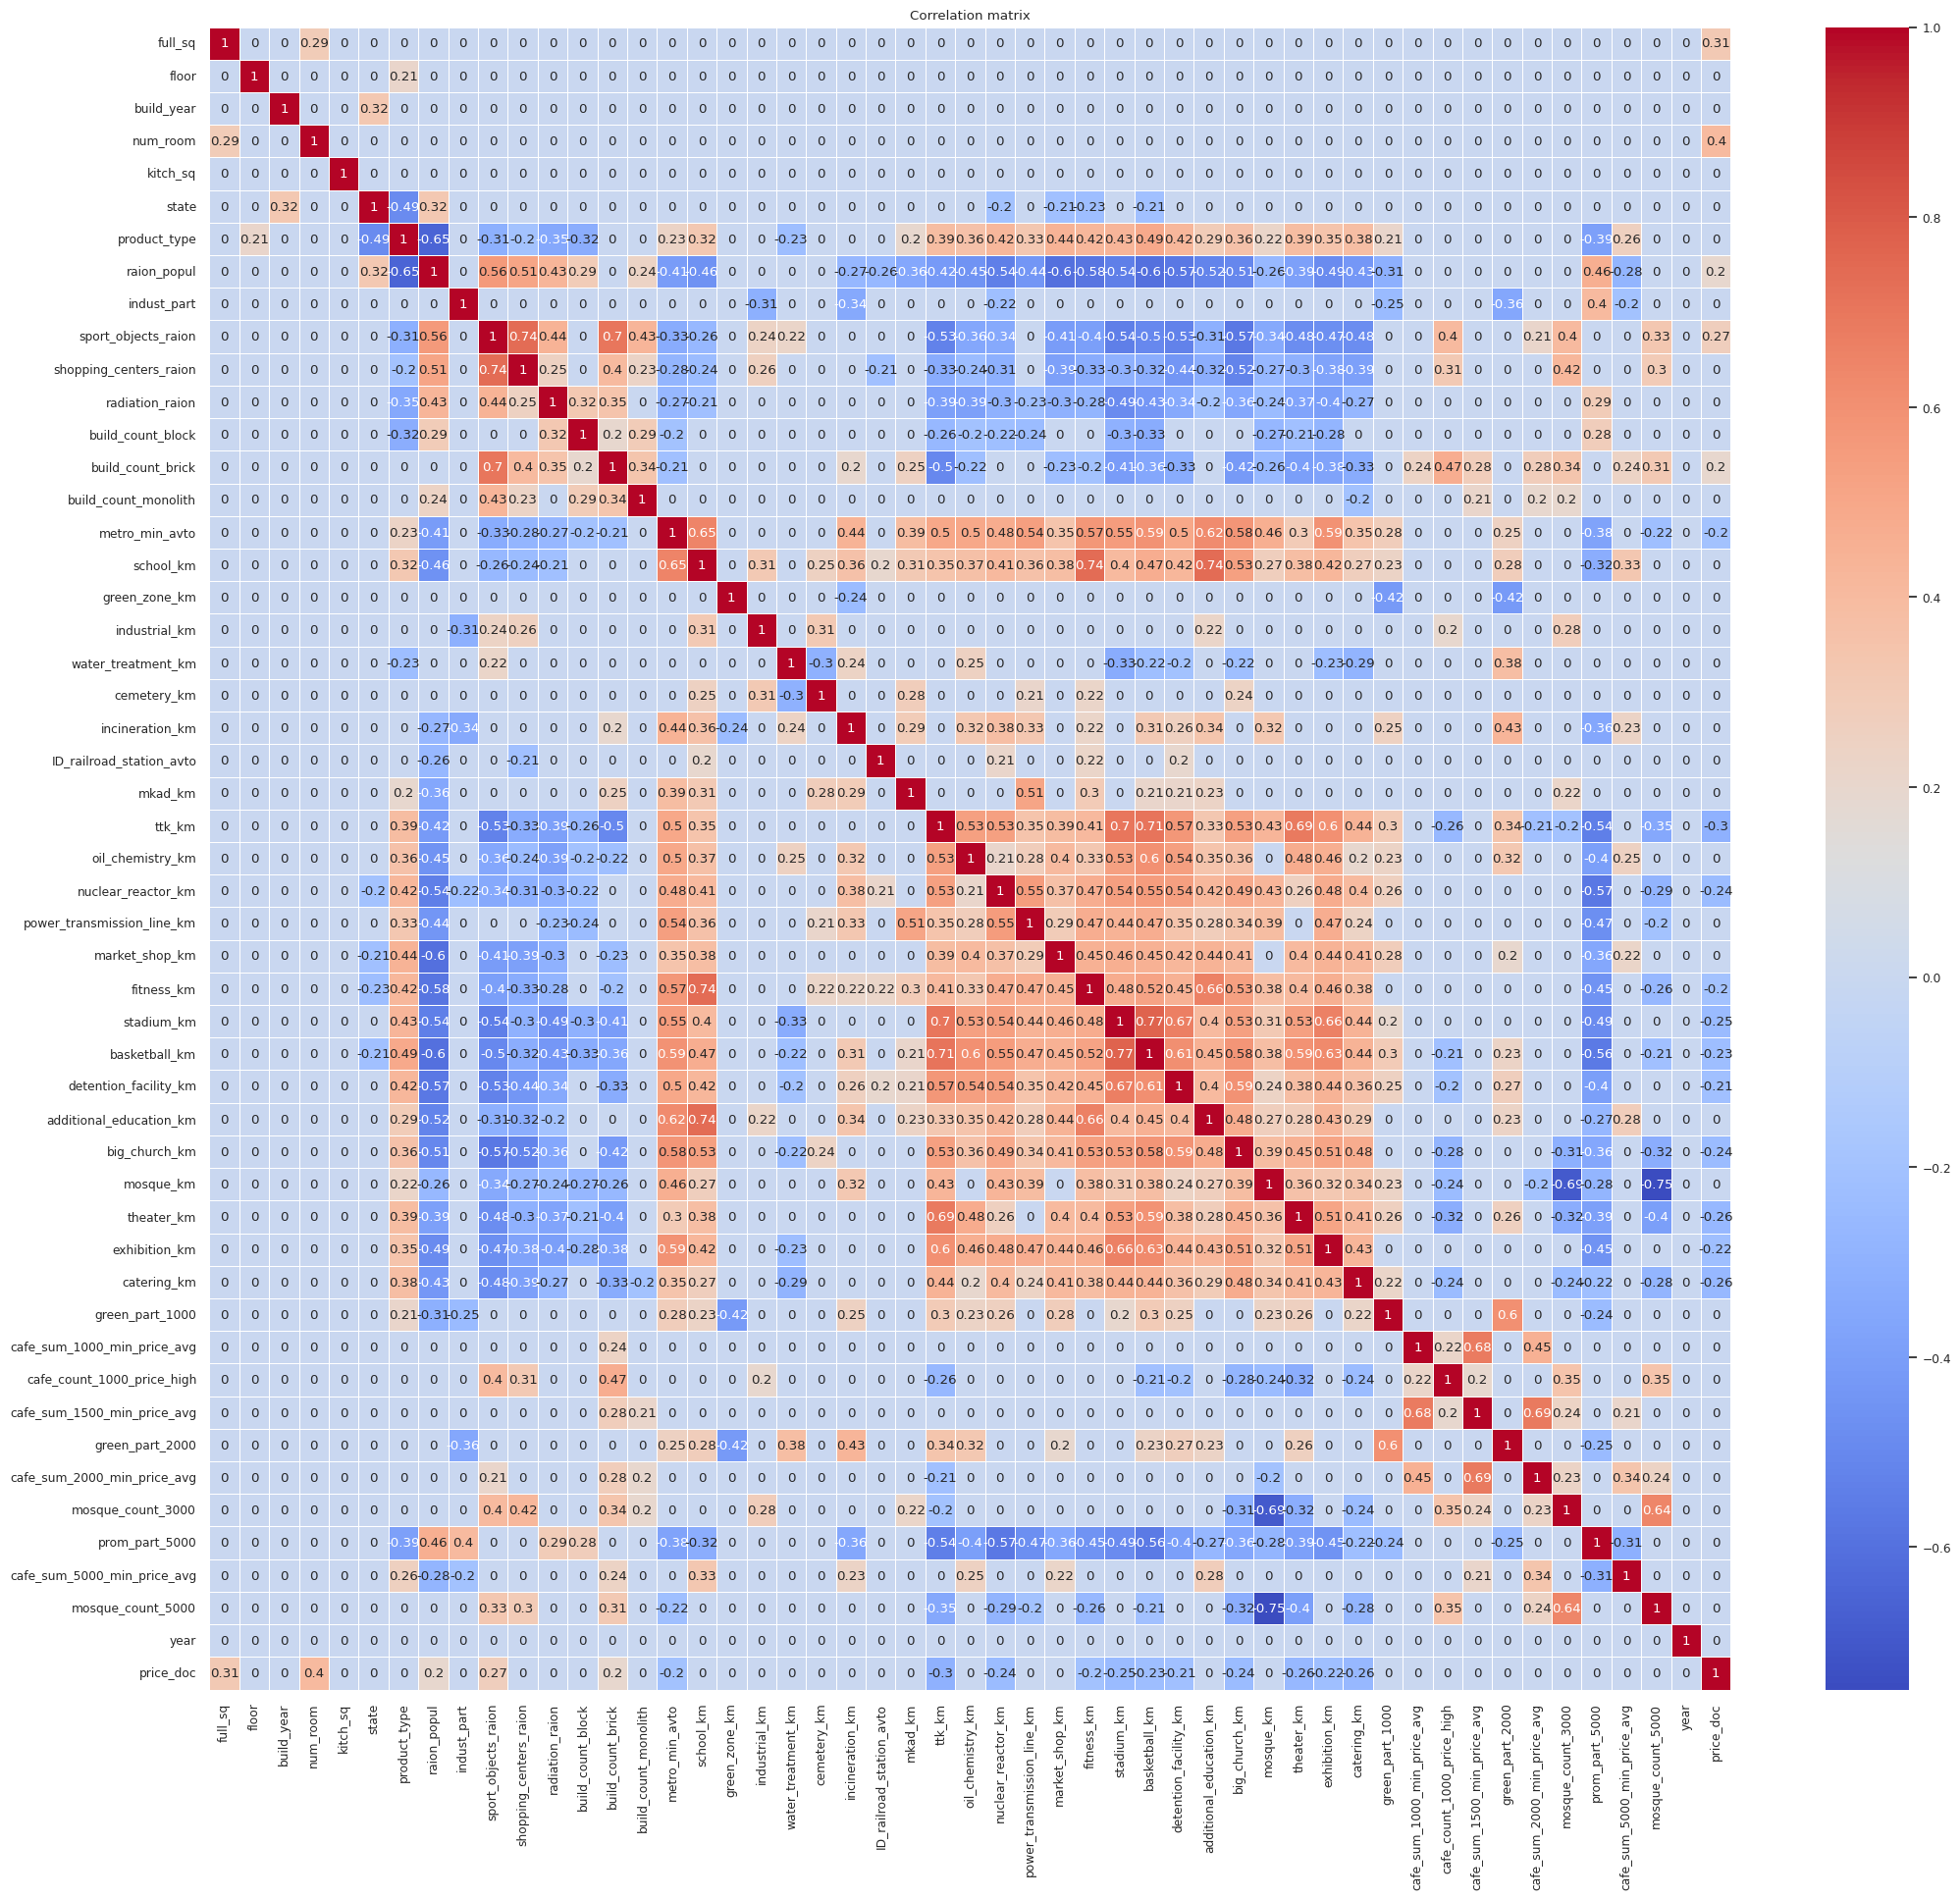

In [ ]:
plt.figure(figsize = (25,22))

sns.set(font_scale=0.8)

df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16', 'int'])
corr_matrix = df_num_features.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

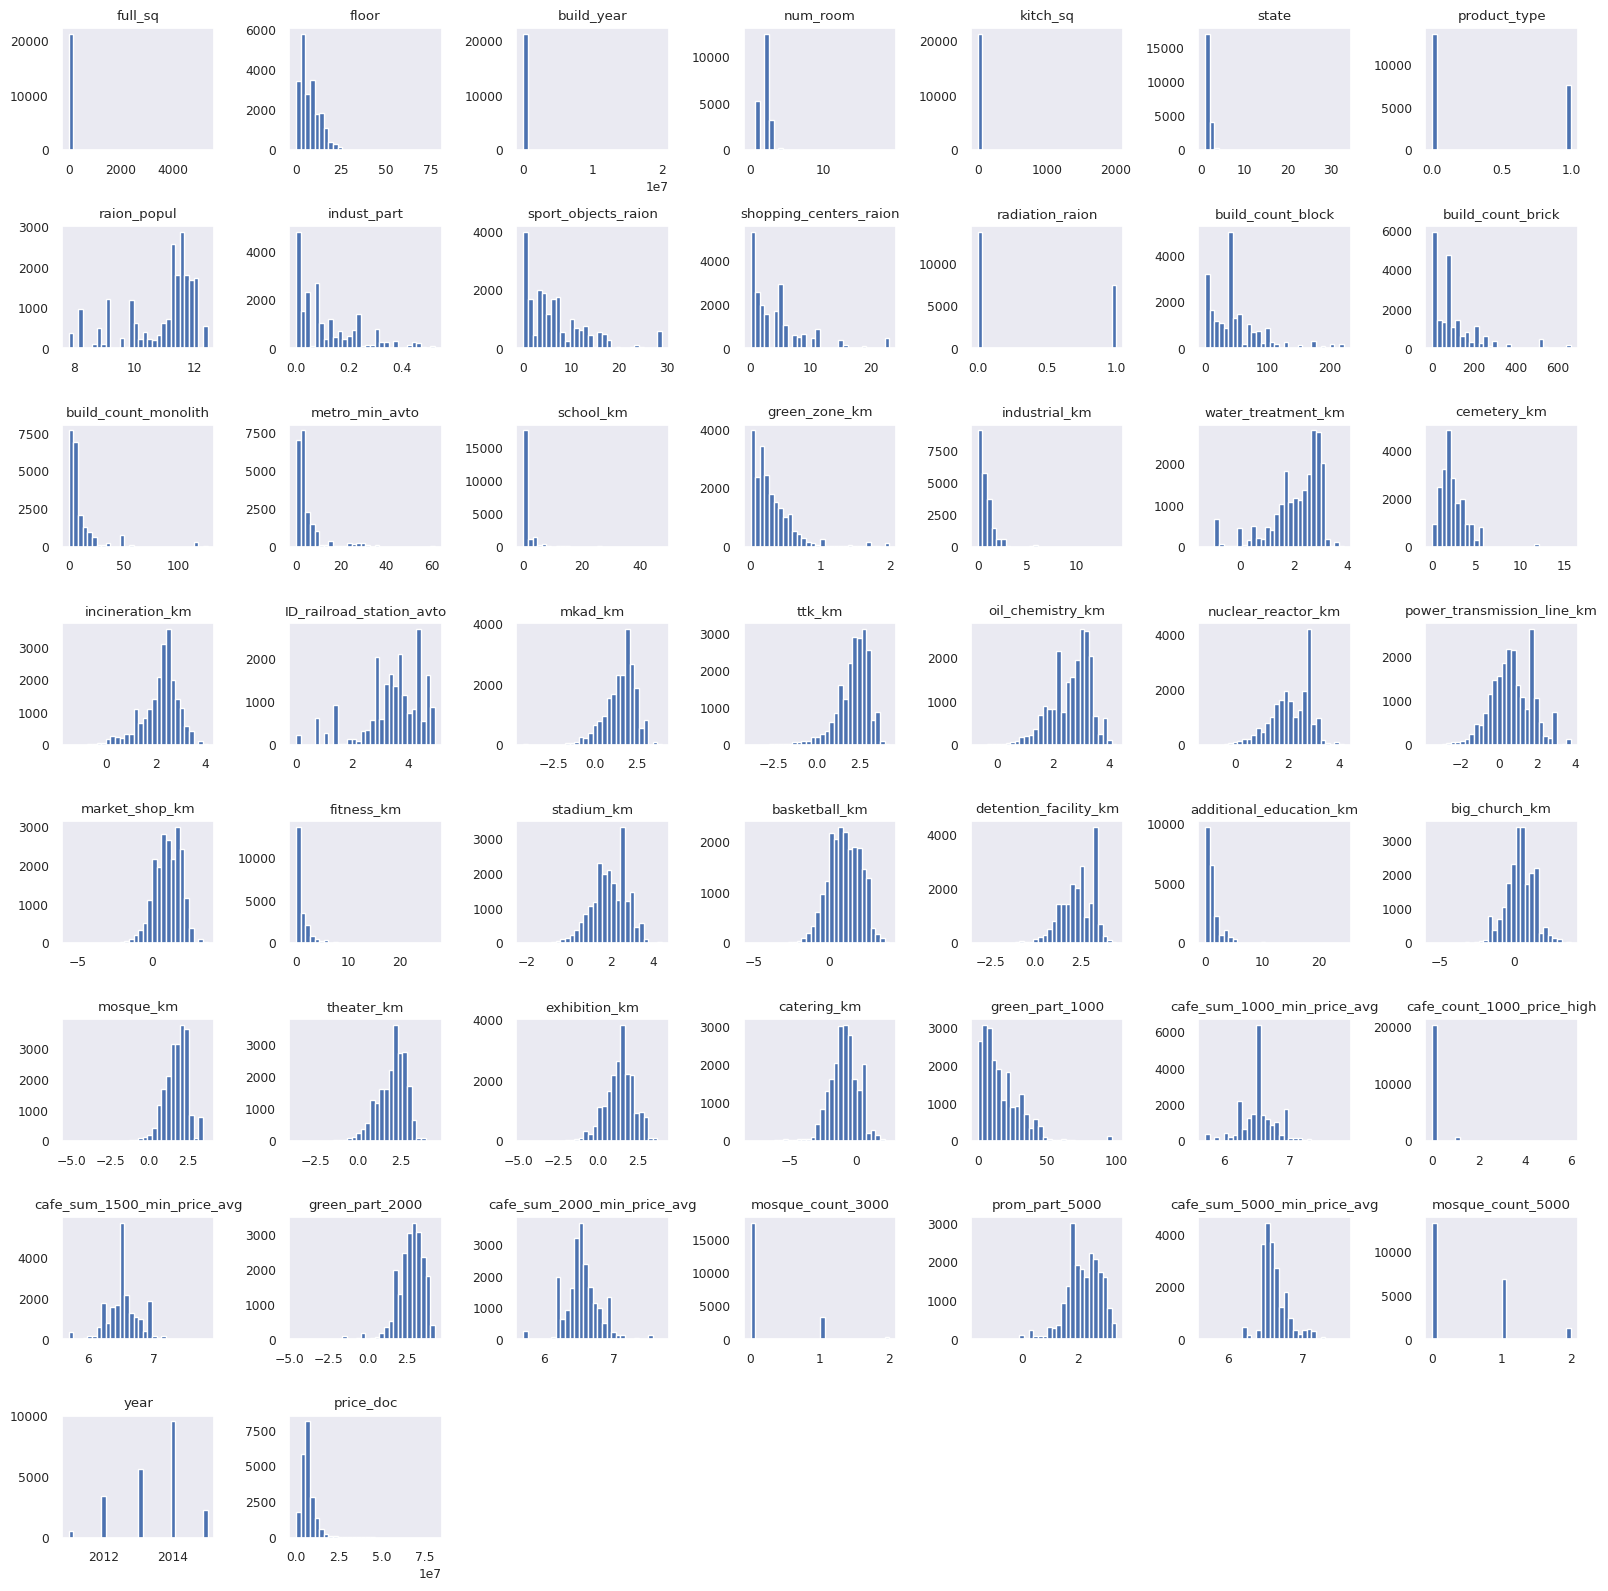

In [ ]:
df.select_dtypes(include=['float64', 'float32', 'float16','int64']).hist(figsize=(16,16), bins=30, grid=False)
plt.tight_layout()

# Изменение данных

In [4]:
def change_df(dff):
    dff = dff.drop_duplicates() # Удаляем дубликаты

    # Временно сносим full_sq
    price_doc = dff['price_doc']
    dff.drop('price_doc', axis=1, inplace=True)

    '''
     "Лечим" данные. Основная идея в том,
     чтобы избавиться от аномально больших или аномально малых значений,
     но не удаляя их, а изменяя на более усредненные
     '''

    '''
    Все значения подобраны методом многократного тестирования,
    основываясь на средних значениях характеристики дома.
    '''

    '''
    Как показали тесты, параметр full_sq оказывает наибольшее влияние
    на прогнозирование цены дома, поэтому ему было уделено особое внимание.
    '''
    dff['full_sq'][(dff['full_sq'] > 1000)] = 45

    '''
    Дома с площадью > 250 намного чаще дешевле, чем дороже,
    и модель часто ошибается на таких домах.
    Выглядит так, что значениям просто случайно дописали 0.
    Изменение оказалось очень эффективным
    '''
    dff['full_sq'][(dff['full_sq'] > 250)] = dff['full_sq']/10

    dff['full_sq'][(dff['full_sq'] == 0)] = 1
    dff['full_sq'][(dff['full_sq'] == 1)] = 66
    dff['full_sq'][(dff['full_sq'] == 5)  | (dff['full_sq'] == 6)] = 45
    dff['full_sq'][(dff['full_sq'] == 9)] = 52

    '''
    Исходя из размышлений, что модель может лучше обучиться, зная,
    что парметр принимал аномальное значение,
    решено было ввести фичи fixed_floor и fixed_year.
    Так же обрабатываются редкие или
    "сломанные" значения у фич 'floor' и 'build_year'
    '''
    dff['fixed_floor'] = 0
    dff.loc[dff['floor'] > 30, 'fixed_floor'] = 1
    dff.loc[dff['floor'] == 0, 'fixed_floor'] = -1
    dff['floor'][(dff['floor'] > 30)] = 30

    dff['fixed_year'] = 0
    dff.loc[dff['build_year'] <=1850, 'fixed_year'] = 1
    dff.loc[dff['build_year'] > 2024, 'fixed_year'] = -1
    dff['build_year'][(dff['build_year'] > 2024)] = 2005
    dff['build_year'][(dff['build_year'] < 1850)] = 1960

    '''
    У "километровых" фич наблюдаются "хвосты" - редкие значения далеко за
    пределом нормального диапазона
    При этом средняя цена у таких аномальных значений почти всегда такая же,
    как и в нормальном диапазоне
    Таким образом, имеет смысл убрать эти самые хвосты и привести фичи к более
    нормальному распределению значений
    '''
    dff['school_km'][(dff['school_km'] > 10)] = np.sqrt(np.sqrt(dff['school_km'])) + 8
    dff['fitness_km'][(dff['fitness_km'] > 5)] = np.sqrt(np.sqrt(dff['fitness_km'])) + 3.5
    dff['cemetery_km'][(dff['cemetery_km'] > 5.75)] = np.sqrt(np.sqrt(dff['cemetery_km'])) + 3.5
    dff['additional_education_km'][(dff['additional_education_km'] > 6)] = np.sqrt(np.sqrt(dff['additional_education_km'])) + 4
    dff['metro_min_avto'][(dff['metro_min_avto'] > 30)] = np.sqrt(np.sqrt(dff['metro_min_avto'])) + 27
    dff['metro_min_avto'][(dff['metro_min_avto'] > 10)] = np.sqrt(np.sqrt(dff['metro_min_avto'])) + 2.5
    dff['catering_km'][(dff['catering_km'] <- 6)] = -6
    dff['catering_km'][(dff['catering_km'] < 0)] = np.sqrt(np.abs(dff['catering_km']))
    dff['industrial_km'][(dff['industrial_km'] > 2.8)] = 2.8

    # Иногда можно взять спектр значений по модулю или сделать другие преобразования
    dff['mosque_km'][(dff['mosque_km'] < -1)] = np.abs(dff['mosque_km']) * 0.35
    dff['ttk_km'][(dff['ttk_km'] < -2)] = np.abs(dff['ttk_km']) * 0.35
    dff['theater_km'][(dff['theater_km'] < -1.5)] = np.abs(dff['theater_km']) * 0.35
    dff['theater_km'][(dff['theater_km'] > 3.5)] = np.sqrt(np.sqrt(dff['theater_km'])) + 2.5
    dff['market_shop_km'][(dff['market_shop_km'] < -2.5)] = 0
    dff['market_shop_km'][(dff['market_shop_km'] > 3)] = 0

    # Немного улучшает итоговый результат.
    dff['mosque_count'] = np.sqrt(np.abs(dff['mosque_count_3000'] * dff['mosque_count_5000']))
    dff.drop('mosque_count_3000', axis=1,inplace=True)
    dff.drop('mosque_count_5000', axis=1,inplace=True)

    # Эта фича имеет бракованные значения и не представляет особой пользы. Можно её просто удалить
    dff.drop('kitch_sq', axis=1, inplace=True)

    # Введение этой фичи обосновано тем, full_sq и num_room одни из самых полезных признаков. Возможно эта фича может их как то связать
    dff['ExpensiveMeter1'] = dff['full_sq'] * dff['num_room']
    dff['ExpensiveMeter1'][(dff['ExpensiveMeter1'] > 700)] = 700
    dff['ExpensiveMeter1'][(dff['ExpensiveMeter1'] < 25)] = 25

    '''
    Попытка связать radiation_raion и full_sq, потому что иногда отмечалась
    закономерность распределения этих двух фич на домах,
    на которых модель ошибается больше всего
    '''
    dff['ExpensiveMeter2'] = dff['radiation_raion'] * np.sqrt(dff['full_sq'])

    # Попытка связать 2 категориальных признака
    dff['Test2'] = dff['product_type'] + dff['radiation_raion']

    # Попытка связать raion_popul и num_room
    dff['Test3'] = dff['num_room'] * dff['raion_popul']

    #Модель крайне часто сильно ошибается на домах с product_type=0 и с большой full_sq. Часто такие дома дешевые, а модель думает, что они дорогие
    dff['Test4'] = (dff['product_type'] + 2) * np.sqrt(dff['full_sq'])

    # Была обнаружена связь между этими тремя параметрами на выборке домов, на которых модель сильно ошибается
    dff['Test5'] = np.minimum(dff['cemetery_km'], dff['oil_chemistry_km']) * dff['full_sq']

    # Попытки связать / объединить 2 фичи
    dff['Test6'] = dff['indust_part'] * dff['raion_popul']
    dff['Test7'] = dff['stadium_km'] * dff['basketball_km']
    dff['Test8'] = dff['sport_objects_raion'] * dff['shopping_centers_raion']
    dff['Test9'] = dff['cafe_sum_1000_min_price_avg'] * dff['cafe_sum_1500_min_price_avg']

    # Логичные и полезные фичи
    dff['Room_area'] = dff['full_sq'] / (dff['num_room'] + 1)
    dff['build_age'] = dff['year'] - dff['build_year']

    '''
    Попытка объединить значения фич в большие группы.
    Предполагается, что модель может найти некоторые доп. закономерности
    в связке с неокругленными версиями этих фич
    '''
    dff['full_sq2'] = np.floor(dff['full_sq'] / 20) * 20
    dff['ttk_km2'] = np.floor(dff['ttk_km'] * 2) / 2
    dff['school_km2'] = np.floor(dff['school_km'] * 2) / 2
    dff['theater_km2'] = np.floor(dff['theater_km'] * 2) / 2
    dff['cemetery_km2'] = np.floor(dff['cemetery_km'] * 2) / 2
    dff['fitness_km2'] = np.floor(dff['fitness_km'] * 2) / 2
    dff['market_shop_km2'] = np.floor(dff['market_shop_km'] * 2) / 2
    dff['additional_education_km2'] = np.floor(dff['additional_education_km'] * 2) / 2
    dff['raion_popul2'] = np.floor(dff['raion_popul'] * 2) / 2
    dff['build_year2'] = np.floor(dff['build_year'] / 15) * 15
    dff['build_age2'] = np.floor(dff['build_age'] / 10) * 10
    dff['floor2'] = np.floor(dff['floor'] / 5) * 5
    dff['shopping_centers_raion2'] = np.floor(dff['shopping_centers_raion'] / 5) * 5
    dff['build_count_block2'] = np.floor(dff['build_count_block'] / 25) * 25
    dff['build_count_brick2'] = np.floor(dff['build_count_brick'] / 25) * 25
    dff['build_count_monolith2'] = np.floor(dff['build_count_monolith'] / 20) * 20
    dff['metro_min_avto2'] = np.floor(dff['metro_min_avto'] / 1.5) * 1.5
    dff['green_zone_km2'] = np.floor(dff['green_zone_km'] / 0.3) * 0.3
    dff['industrial_km2'] = np.floor(dff['industrial_km'] / 0.3) * 0.3
    dff['water_treatment_km2'] = np.floor(dff['water_treatment_km'] / 0.4) * 0.4
    dff['incineration_km2'] = np.floor(dff['incineration_km'] / 0.5) * 0.5
    dff['ID_railroad_station_avto2'] = np.floor(dff['ID_railroad_station_avto'] / 0.5) * 0.5
    dff['mkad_km2'] = np.floor(dff['mkad_km'] / 0.75) * 0.75
    dff['oil_chemistry_km2'] = np.floor(dff['oil_chemistry_km'] / 0.6) * 0.6
    dff['nuclear_reactor_km2'] = np.floor(dff['nuclear_reactor_km'] / 0.6) * 0.6
    dff['power_transmission_line_km2'] = np.floor(dff['power_transmission_line_km'] / 0.6) * 0.6
    dff['basketball_km2'] = np.floor(dff['basketball_km'] / 0.6) * 0.6
    dff['detention_facility_km2'] = np.floor(dff['detention_facility_km'] / 0.6) * 0.6
    dff['catering_km2'] = np.floor(dff['catering_km'] / 0.4) * 0.4
    dff['mosque_km2'] = np.floor(dff['mosque_km'] / 0.5) * 0.5
    dff['exhibition_km2'] = np.floor(dff['exhibition_km'] / 0.75) * 0.75
    dff['big_church_km2'] = np.floor(dff['big_church_km'] / 0.75) * 0.75
    dff['cafe_sum_1000_min_price_avg2'] = np.floor(dff['cafe_sum_1000_min_price_avg'] / 0.5) * 0.5
    dff['cafe_sum_1500_min_price_avg2'] = np.floor(dff['cafe_sum_1500_min_price_avg'] / 0.5) * 0.5
    dff['cafe_sum_2000_min_price_avg2'] = np.floor(dff['cafe_sum_2000_min_price_avg'] / 0.75) * 0.75
    dff['cafe_sum_5000_min_price_avg2'] = np.floor(dff['cafe_sum_2000_min_price_avg'] / 0.3) * 0.3
    dff['green_part_10002'] = np.floor(dff['green_part_1000'] / 15) * 15
    dff['green_part_20002'] = np.floor(dff['green_part_2000'] / 0.8) * 0.8
    dff['prom_part_50002'] = np.floor(dff['prom_part_5000'] / 0.4) * 0.4
    dff['Room_area2'] = np.floor(dff['Room_area'] / 15) * 15

    return dff

# Визуализация после изменений

In [ ]:
df_new = change_df(df)

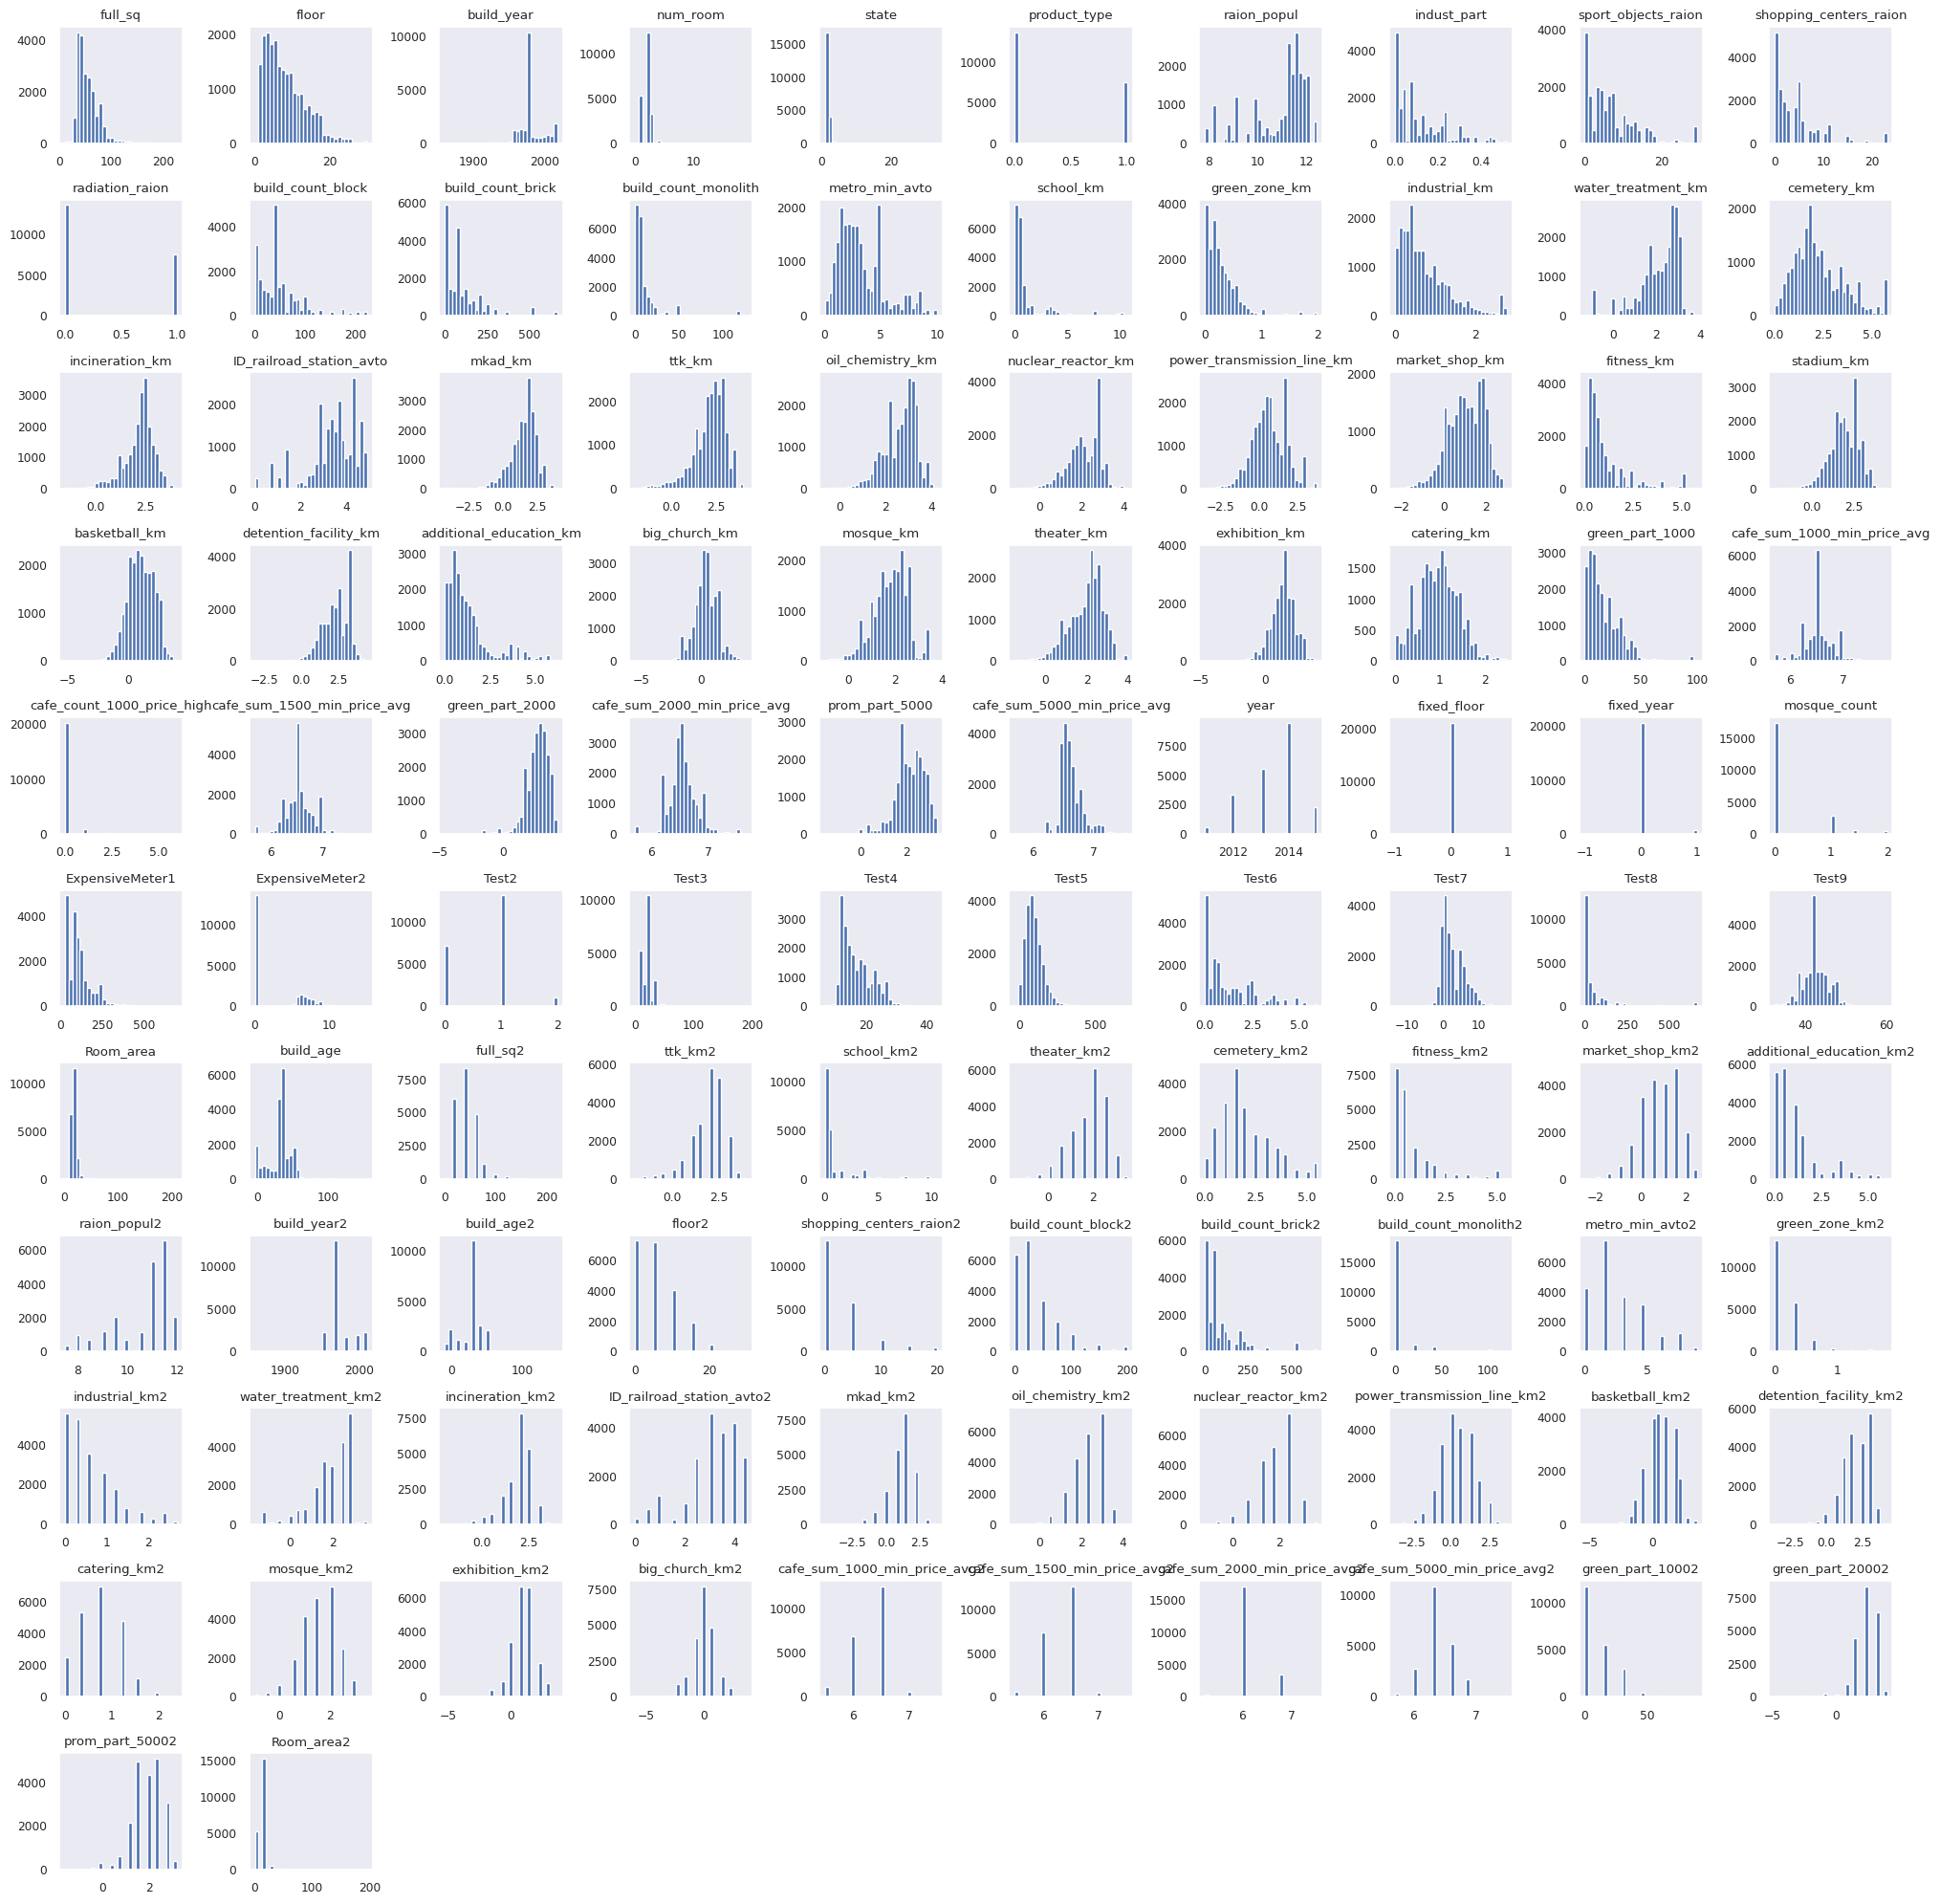

In [ ]:
df_new.select_dtypes(include=['float64', 'float32', 'float16','int64']).hist(figsize=(20,20), bins=30, grid=False)
plt.tight_layout()

df.select_dtypes(include=['float64', 'float32', 'float16','int64']).hist(figsize=(20,20), bins=30, grid=False)
plt.tight_layout()

Таким образом, благодаря этим преобразованиям удалось добиться существенного снижения ошибки.